<a href='#1'>1. Data's Overview</a>

<a href='#2'>2. Simple EDA</a>

<a href='#3'>3. Simple FE</a>

<a href='#4'>4. Model</a>

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots
import datetime # manipulating date formats

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ashrae-energy-prediction/sample_submission.csv
/kaggle/input/ashrae-energy-prediction/building_metadata.csv
/kaggle/input/ashrae-energy-prediction/weather_train.csv
/kaggle/input/ashrae-energy-prediction/weather_test.csv
/kaggle/input/ashrae-energy-prediction/train.csv
/kaggle/input/ashrae-energy-prediction/test.csv


# <a id='1'>1. Data's Overview</a>

## Loading data

In [3]:
building_metadata = pd.read_csv('/kaggle/input/ashrae-energy-prediction/building_metadata.csv')
train = pd.read_csv('/kaggle/input/ashrae-energy-prediction/train.csv')
test = pd.read_csv('/kaggle/input/ashrae-energy-prediction/test.csv')
weather_train = pd.read_csv('/kaggle/input/ashrae-energy-prediction/weather_train.csv')
weather_test = pd.read_csv('/kaggle/input/ashrae-energy-prediction/weather_test.csv')

In [4]:
#Function to reduction memory usage (Source code from Kaggle)
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [5]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)
building_metadata = reduce_mem_usage(building_metadata)
weather_train = reduce_mem_usage(weather_train)
weather_test = reduce_mem_usage(weather_test)

Memory usage after optimization is: 289.19 MB
Decreased by 53.1%
Memory usage after optimization is: 596.49 MB
Decreased by 53.1%
Memory usage after optimization is: 0.03 MB
Decreased by 60.3%
Memory usage after optimization is: 3.07 MB
Decreased by 68.1%
Memory usage after optimization is: 6.08 MB
Decreased by 68.1%


## Data's overview

In [6]:
print('Size of train data', train.shape)
print('Size of test data', test.shape)
print('Size of weather_train data', weather_train.shape)
print('Size of weather_test data', weather_test.shape)
print('Size of building_metadata data', building_metadata.shape)

Size of train data (20216100, 4)
Size of test data (41697600, 4)
Size of weather_train data (139773, 9)
Size of weather_test data (277243, 9)
Size of building_metadata data (1449, 6)


In [7]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [8]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609


In [9]:
building_metadata.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


## Merge data

In [10]:
train_merge = train.merge(building_metadata, on='building_id', how='left')
test_merge = test.merge(building_metadata, on='building_id', how='left')

train_merge = train_merge.merge(weather_train, on=['site_id', 'timestamp'], how='left')
test_merge = test_merge.merge(weather_test, on=['site_id', 'timestamp'], how='left')

In [11]:
#del building_metadata, weather_train, weather_test, train, test

import gc
gc.collect()

20

Check NA data

In [12]:
train_merge.isna().sum(axis = 0)

building_id                  0
meter                        0
timestamp                    0
meter_reading                0
site_id                      0
primary_use                  0
square_feet                  0
year_built            12127645
floor_count           16709167
air_temperature          96658
cloud_coverage         8825365
dew_temperature         100140
precip_depth_1_hr      3749023
sea_level_pressure     1231669
wind_direction         1449048
wind_speed              143676
dtype: int64

In [13]:
test_merge.isna().sum(axis = 0)

row_id                       0
building_id                  0
meter                        0
timestamp                    0
site_id                      0
primary_use                  0
square_feet                  0
year_built            24598080
floor_count           34444320
air_temperature         221901
cloud_coverage        19542180
dew_temperature         260799
precip_depth_1_hr      7801563
sea_level_pressure     2516826
wind_direction         2978663
wind_speed              302089
dtype: int64

# <a id='2'>2. EDA</a>

## Target variable: meter_reading
 - Type 0 (electricity) of meter are mesure in kBTU. We need to convert them to kWh, and convert the prediction of this type again to kBTU before submission.
 - Problem of outliers. We will investigate more this problem after. Now we just consider remove outliers by simple method IQR.

In [14]:
train_merge.loc[train_merge.meter == 0 , 'meter_reading'] = train_merge.loc[train_merge.meter == 0 , 'meter_reading'] * 0.2931

In [16]:
train_merge.meter_reading.describe()

count    2.021610e+07
mean     1.958269e+03
std      1.532163e+05
min      0.000000e+00
25%      6.353177e+00
50%      3.080891e+01
75%      1.383432e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

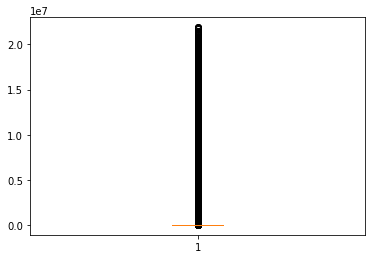

In [17]:
plt.boxplot(train_merge.meter_reading)
plt.show()

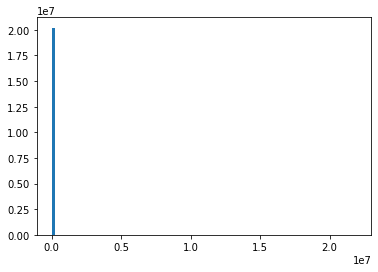

In [18]:
plt.hist(train_merge.meter_reading, bins = 100)
plt.show()

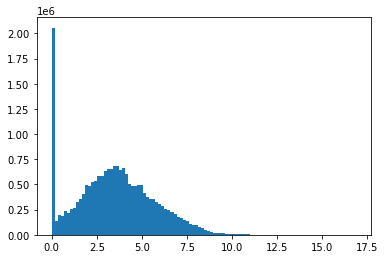

In [19]:
plt.hist(np.log1p(train_merge.meter_reading), bins = 100)
plt.show()

### Remove outliers using IQR

In [20]:
train_0 = train_merge[train_merge.meter_reading > 0]

In [21]:
Q1 = train_0.meter_reading.quantile(0.25)
Q3 = train_0.meter_reading.quantile(0.75)
IQR = Q3 - Q1
del train_0
gc.collect()
#train_IQR = train_merge[train_merge.meter_reading <= Q3 + 1.5 * IQR]

20925

## Explicative Variables

# <a id='3'>3. FE</a>

With the problem of the form of time series, we can create some useful variables. For example: year, month, date, hour, lagged variables. We will start with the simple ones: year, month, date, hour.

In [22]:
train_merge.timestamp = pd.to_datetime(train_merge.timestamp)
test_merge.timestamp = pd.to_datetime(test_merge.timestamp)

In [23]:
train_merge['month'] = train_merge['timestamp'].dt.month.astype(np.int8)
#train_merge['year'] = train_merge['timestamp'].dt.year.astype(np.int16)
train_merge['day'] = train_merge['timestamp'].dt.dayofweek.astype(np.int8)
train_merge['week'] = train_merge['timestamp'].dt.weekofyear.astype(np.int8)
train_merge['hour'] = train_merge['timestamp'].dt.hour.astype(np.int8)

test_merge['month'] = test_merge['timestamp'].dt.month.astype(np.int8)
#test_merge['year'] = test_merge['timestamp'].dt.year.astype(np.int16)
test_merge['day'] = test_merge['timestamp'].dt.dayofweek.astype(np.int8)
test_merge['week'] = test_merge['timestamp'].dt.weekofyear.astype(np.int8)
test_merge['hour'] = test_merge['timestamp'].dt.hour.astype(np.int8)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # Remove the CWD from sys.path while we load stuff.


In [24]:
gc.collect()

20

# <a id='4'>4. Simple model</a>

In [25]:
from sklearn.tree import DecisionTreeRegressor

train_IQR = train_merge[train_merge.meter_reading <= Q3 + 1.5 * IQR]
y_train = train_IQR['meter_reading']
x_train = train_IQR.dropna(axis = 1)
del train_IQR, train_merge
gc.collect()

x = pd.get_dummies(x_train[['primary_use']],drop_first=True)
x_train = pd.concat([x_train, x], axis = 1)
x_train = x_train.drop(['primary_use','meter_reading', 'timestamp'], axis = 1)

x = pd.get_dummies(test_merge[['primary_use']],drop_first=True)
x_test = pd.concat([test_merge, x], axis = 1)
x_test = x_test.drop(['primary_use', 'timestamp'], axis = 1)
x_test = x_test.dropna(axis = 1)
x_test = x_test.drop('row_id', axis = 1)

In [26]:
tree_model = DecisionTreeRegressor(min_samples_split = 200, min_samples_leaf = 100)
tree_model = tree_model.fit(x_train, y_train)

In [27]:
y_pred = tree_model.predict(x_test)
y_pred[x_test.meter==0] = y_pred[x_test.meter==0] / 0.2931

In [32]:
my_submission = pd.DataFrame({'row_id': test_merge.row_id, 'meter_reading': y_pred})
my_submission.to_csv('first_submission.csv', index=False)